<a href="https://colab.research.google.com/github/sarahdell/DSPS_SDellorco/blob/main/hw6/Dellorco_gaussian_process_regression_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.datasets import elnino
import datetime
from scipy.optimize import minimize

!pip install george
import george
from george import kernels
from george.kernels import ExpSine2Kernel
from george import GP
from statsmodels.tsa.seasonal import seasonal_decompose

# 0. The Dataset

In [2]:
def load_elnino_dataset():
    """
    Downloads the El Niño dataset from the statsmodels package.

    Parameters
    ----------
    None

    Returns
    -------
    df : pd.DataFrame
        A Pandas dataframe containing the raw data of the El Niño dataset
        directly from the statsmodels package.
    """
    df = elnino.load_pandas().data
    return df

df = load_elnino_dataset()

In [3]:
df

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1950.0,23.11,24.20,25.37,23.86,23.03,21.57,20.63,20.15,19.67,20.03,20.02,21.80
1,1951.0,24.19,25.28,25.60,25.37,24.79,24.69,23.86,22.32,21.44,21.77,22.33,22.89
2,1952.0,24.52,26.21,26.37,24.73,23.71,22.34,20.89,20.02,19.63,20.40,20.77,22.39
3,1953.0,24.15,26.34,27.36,27.03,25.47,23.49,22.20,21.45,21.25,20.95,21.60,22.44
4,1954.0,23.02,25.00,25.33,22.97,21.73,20.77,19.52,19.33,18.95,19.11,20.27,21.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2006.0,24.76,26.52,26.22,24.29,23.84,22.82,22.20,21.89,21.93,22.46,22.61,24.15
57,2007.0,25.82,26.81,26.41,24.96,23.05,21.61,21.05,19.95,19.85,19.31,19.82,21.15
58,2008.0,24.24,26.39,26.91,25.68,24.43,23.19,23.02,22.14,21.60,21.39,21.54,22.73
59,2009.0,24.39,25.53,25.48,25.84,24.95,24.09,23.09,22.03,21.48,21.64,21.99,23.21


In [4]:
def flatten_dataset(df):
    """
    Flatten the data in the dataframe.

    Parameters
    ----------
    df : pd.DataFrame
        The Pandas dataframe of the El Niño – Sea Surface Temperature dataset.

    Returns
    -------
    time : list
        A list containing strings in the form "Month Year" (e.g., "January 1950").
    data : list
        A list containing the sea surface temperature for each corresponding "Month Year."
    """
    # Initialize empty lists to store time and data
    time = []
    data = []

    # Iterate through the rows of the DataFrame
    for index, row in df.iterrows():
        year = int(row['YEAR'])
        for month in range(1, 13):
            # Construct the time in the format "Month Year"
            month_name = df.columns[month]
            time.append(f"{month_name} {year}")

            # Get the sea surface temperature for the corresponding year and month
            temperature = row[month_name]
            data.append(temperature)

    return time, data

# Call the function to get the flattened data
x, y = flatten_dataset(df)

In [5]:
flatten_df = pd.DataFrame({'x': x, 'y': y})
flatten_df

,x,y
0,JAN 1950,23.11
1,FEB 1950,24.20
2,MAR 1950,25.37
3,APR 1950,23.86
4,MAY 1950,23.03
...,...,...
727,AUG 2010,19.49
728,SEP 2010,19.28
729,OCT 2010,19.73
730,NOV 2010,20.44


# 1. Visualize

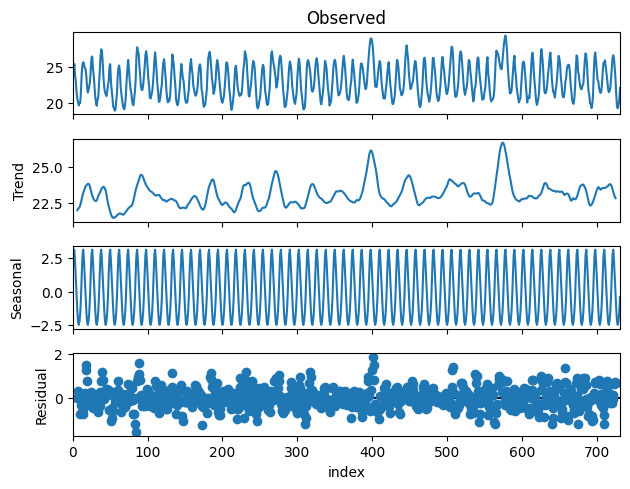

In [6]:
freq = 12  # Since it's monthly data
result = seasonal_decompose(y, model="additive", period=freq)
result.plot()
plt.xlabel('index')
plt.show()

**Figure 1:** The "Observed" part of this plot is just a line plot of the data showing the temperature of the sea surface vs time. The "Seasonal" part of the plot shows a clear pattern, so we can indeed determine that the data shows seasonal/periodic characteristics. This is helpful in choosing a kernel for the GPR, because we know it will be better to choose a periodic kernel. The x axis shows the index (row number).

# <mark>WFF</mark> This is a very interesting plot! It needs more explanation though because the labels are, at leaast to me, not sufficient to make it clear exactly what is going on at first glance. So the top panel shows the original data. The "Trend" panel shows a smoothed version of the data, but I am not sure how it is smoothed. The "Seasonal" panel shows some sort of periodic fit to the data (very cool) and the "Residual" panel shows the difference between the first and third panels? Or the second and third panels? You also should have stated specifically that the x-axis is time.

<ipython-input-7-df1f18308701>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  BuRd = plt.cm.get_cmap('RdBu', 256)


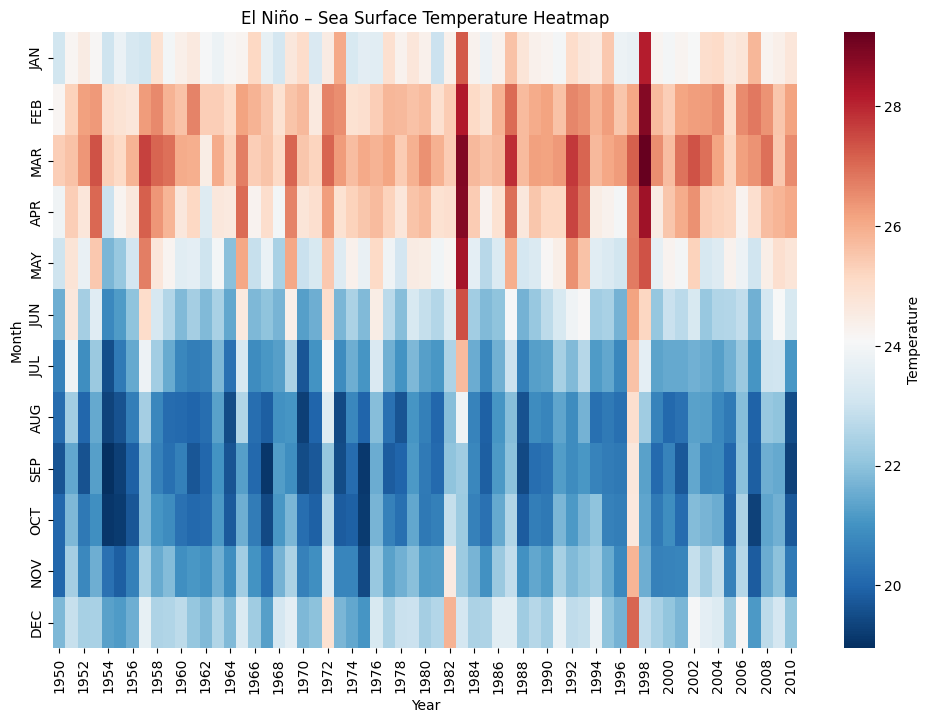

In [7]:
BuRd = plt.cm.get_cmap('RdBu', 256)
BuRd = BuRd.reversed() #switched it so red would be hotter than blue
heatmap_data = df.iloc[:, 1:].copy()
heatmap_data.index = range(1950, 2011)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, cmap=BuRd, cbar_kws={'label': 'Temperature'})
plt.title('El Niño – Sea Surface Temperature Heatmap')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

**Figure 2:** The heatmap shows the same general trend that the temperature generally cycles periodically. We can tell since red tends to fall in the earlier months and blue tends to fall in the later months.

# 2. Gaussian Process Regression (GPR)

In [8]:
def generate_interpolation_time(start_date, end_date, interval):
    """
    Generate an array of time values at regular intervals between start_date and end_date.

    Parameters:
    - start_date: The starting date in the format "YYYY-MM-DD".
    - end_date: The ending date in the format "YYYY-MM-DD".
    - interval: The time interval in days.

    Returns:
    - interp_time: An array of time values at regular intervals.
    """
    start = np.datetime64(start_date)
    end = np.datetime64(end_date)
    interp_time = np.arange(start, end, np.timedelta64(interval, 'D'), dtype='datetime64[D]')
    return interp_time


In [9]:
start_date = '1950-01-01'
end_date = '2030-12-01'
interval = 1  # 1 day interval
interp_time = generate_interpolation_time(start_date, end_date, interval)
interp_time = pd.to_datetime(interp_time, format='%Y-%m-%d', errors='coerce')
interp_time = pd.date_range(interp_time.min(), interp_time.max(), freq='D')

In [10]:
interp_time

DatetimeIndex(['1950-01-01', '1950-01-02', '1950-01-03', '1950-01-04',
               '1950-01-05', '1950-01-06', '1950-01-07', '1950-01-08',
               '1950-01-09', '1950-01-10',
               ...
               '2030-11-21', '2030-11-22', '2030-11-23', '2030-11-24',
               '2030-11-25', '2030-11-26', '2030-11-27', '2030-11-28',
               '2030-11-29', '2030-11-30'],
              dtype='datetime64[ns]', length=29554, freq='D')

In [11]:
#I had x in a different format for month so I have to adjust it here. I'm going to change "JAN" to "January for example".
#This is so in the next cell I can use the format='%B %Y'
formatted_x = [datetime.datetime.strptime(month_year, '%b %Y').strftime('%B %Y') for month_year in x]

In [12]:
formatted_x[:5]

['January 1950', 'February 1950', 'March 1950', 'April 1950', 'May 1950']

In [13]:
data_time = pd.to_datetime(formatted_x, format='%B %Y')
time_numeric = (data_time - data_time.min()).days.values.reshape(-1, 1)
interp_time_numeric = (interp_time - data_time.min()).days.values.reshape(-1, 1)
#using the min to normalize in both time and interp_time numeric

Text(0.5, 1.0, 'Fold Plot')

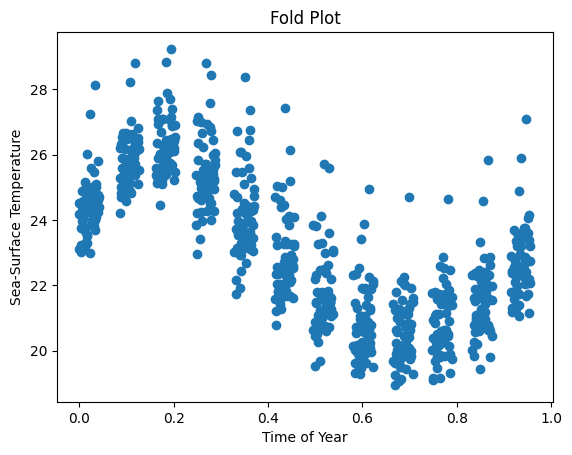

In [14]:
x = time_numeric.ravel()
period_guess=365

folded_x = np.mod(x, period_guess)
phase_x = folded_x/period_guess

plt.scatter(phase_x, y)
plt.xlabel('Time of Year')
plt.ylabel('Sea-Surface Temperature')
plt.title('Fold Plot')

**Figure 3:** The folded plot with period guess chosen as 365 (since there are 365 days in 1 year) shows a sinosoidal pattern, further showing that the periodic kernel is a good choice for a fit.

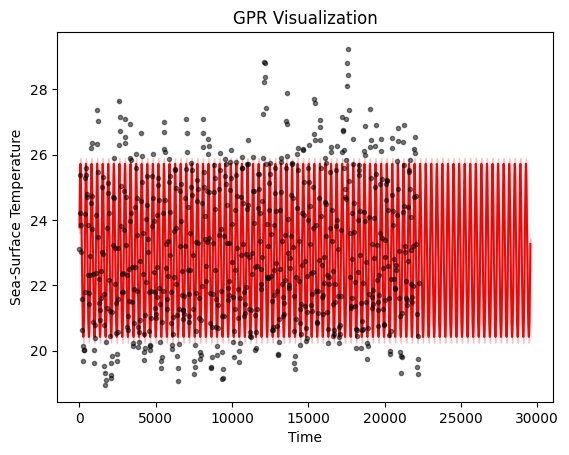

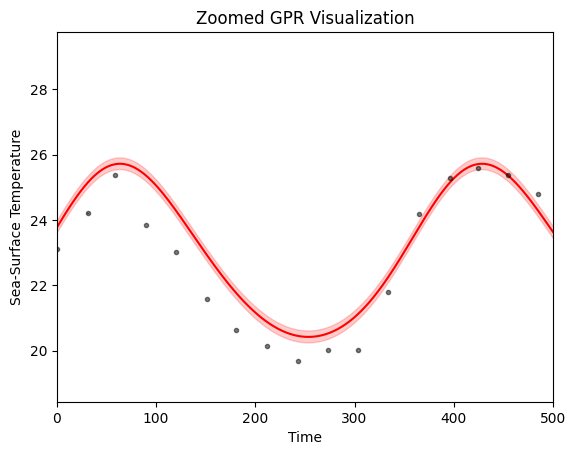

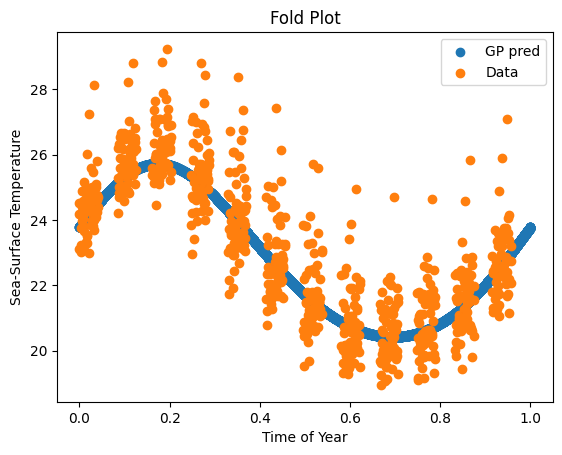

In [18]:
def gaussian_process_regression(time, data, period_guess):
    """
    Perform Gaussian Process Regression (GPR) and plot the results.

    Parameters
    ----------
    x : array-like
        The x-coordinates (time data).
    y : array-like
        The y-coordinates (data to be modeled).
    period_guess : float
        An initial guess for the period parameter of the ExpSine2Kernel.

    Returns
    -------
    None
    """
    kernel = ExpSine2Kernel(1.0, log_period=np.log(period_guess))
    gp = george.GP(kernel)
    gp.compute(time, yerr=np.std(data))

    time_pred = np.linspace(0, 29555, 29555)
    pred, pred_var = gp.predict(data, time_pred, return_var=True)

    plt.fill_between(time_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                     color="r", alpha=0.2)
    plt.plot(time_pred, pred, "r", lw=1.5, alpha=1)
    plt.errorbar(time, data, yerr=np.std(pred_var), fmt=".k", capsize=0,alpha=0.5)
    #plt.errorbar(time, data, yerr=0, fmt=".k", capsize=0,alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Sea-Surface Temperature")
    plt.title('GPR Visualization')
    plt.show()

    plt.fill_between(time_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                     color="r", alpha=0.2)
    plt.plot(time_pred, pred, "r", lw=1.5, alpha=1)
    plt.errorbar(time, data, yerr=np.std(pred_var), fmt=".k", capsize=0,alpha=0.5)
    plt.xlim(0,500)
    #plt.errorbar(time, data, yerr=0, fmt=".k", capsize=0,alpha=0.5)
    plt.xlabel("Time")
    plt.ylabel("Sea-Surface Temperature")
    plt.title('Zoomed GPR Visualization')
    plt.show()

    folded_x_pred = np.mod(np.linspace(0, 29555, 29555), period_guess)
    phase_x_pred = folded_x_pred/period_guess

    plt.scatter(phase_x_pred, pred, label="GP pred")

    plt.scatter(phase_x, y, label="Data")
    plt.legend()
    plt.title('Fold Plot')
    plt.ylabel("Sea-Surface Temperature")
    plt.xlabel("Time of Year")
    plt.show()

period_guess = 365
gaussian_process_regression(x, y, period_guess)


**Figure 4:**

Top: Plot of the real data with the fit generated using Gaussian Process Regression. You can see the data fits the period pretty well, but doesn't really account for the variation in the amplitude.

Middle: A zoomed in version of the top graph for the first 500 days of data. You can see that the generated GPR is a decent fit for the data.

Bottom: The same folded plot as in Figure 3, with the GPR Prediction line plotted. This appears to be a very good fit for the data.

# 3. Optimize

In [16]:
kernel = ExpSine2Kernel(1.0, log_period=np.log(period_guess))
gp = george.GP(kernel, mean=np.mean(y), white_noise=1e-8)
gp.compute(x)
def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1123.9238996835918
        x: [ 1.799e+00  5.900e+00]
      nit: 10
      jac: [ 2.932e-10  2.064e-07]
 hess_inv: [[ 3.217e-01 -5.723e-07]
            [-5.723e-07  2.756e-08]]
     nfev: 15
     njev: 15

Final ln-likelihood: -1123.92


The two parameters in the ExpSine2Kernel are length scale and log period. The length scale controls the smoothness of the periodic component. A larger length scale will result in smoother oscillations. The period is how long one full cycle of the sine graph is. The period determines the frequency of the oscillations. They have an inverse relationship. Log period is the log(period).From the results of the optimize function, we see that the length scale is 1.799 and the log period is 5.9.

# <mark>WFF</mark> Note that $e^{5.9} = 365$, so your optimization did not change things much.

# 4. Visualize your model

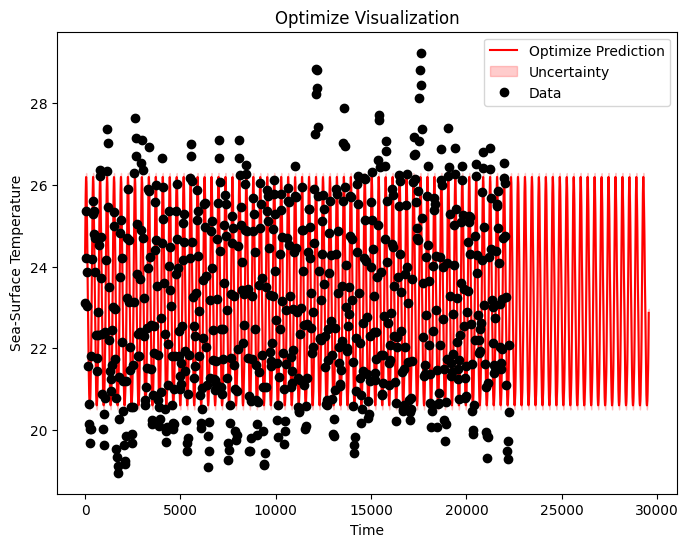

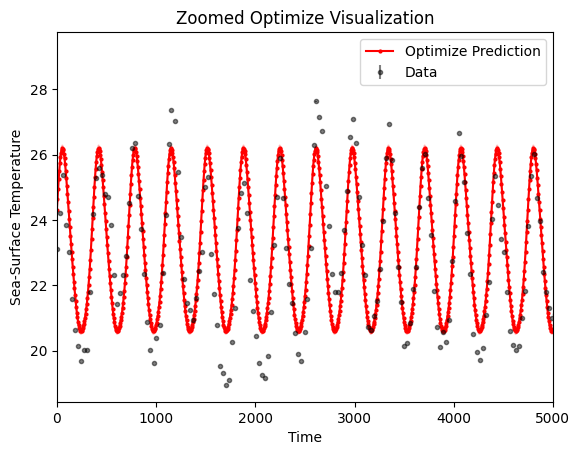

In [17]:
gp.set_parameter_vector(result.x)

# Generate predictions for a range of x-values
x_pred = np.linspace(0, 29555, 5000)
pred, pred_var = gp.predict(y, x_pred, return_var=True)

# Create the visualization plot
plt.figure(figsize=(8, 6))
plt.errorbar(x, y, fmt='ok', capsize=0, label='Data')
plt.plot(x_pred, pred, 'r', lw=1.5, label='Optimize Prediction')
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color='r', alpha=0.2, label='Uncertainty')
plt.xlabel('Time')
plt.ylabel('Sea-Surface Temperature')
plt.legend()
plt.title('Optimize Visualization')
plt.show()

plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                     color="r", alpha=0.2)
plt.plot(x_pred, pred, "r", lw=1.5, alpha=1, marker='o', markersize=2, label="Optimize Prediction")
plt.errorbar(x, y, yerr=np.std(pred_var), fmt=".k", capsize=0,alpha=0.5, label="Data")
plt.xlim(0,5000)
    #plt.errorbar(time, data, yerr=0, fmt=".k", capsize=0,alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Sea-Surface Temperature")
plt.title('Zoomed Optimize Visualization')
plt.legend()
plt.show()


**Figure 5:**

Top: The actual data plotted with the sine fit generated from the parameters found using the optimize function. The fit looks the same as the one in Figure 3, with the same issues. The differences in the amplitudes of the actual data is not able to be reflected by the optimize fit model.

Bottom: A zoomed in version of the Top graph with just the first 5000 days worth of data. The model seems to be a decent fit, but not all of the datapoints are well represented.